# Making training power spectra

**NOTE**: this notebook does **NOT** demonstrate how to use the emulator. It is used to create a set of training cosmologies for use in a separate notebook.

The Boltzmann code emulator require two things:
1. A set of power spectra evaluated at different cosmologies $\{P(k,z,\vec{\Omega}_1),P(k,z,\vec{\Omega}_2),...\}$.
2. A list of cosmological parameters that the power spectra have been evaluated at $\{\vec{\Omega}_1, \vec{\Omega}_2,...\}$.

For emulators based on simulations, one would use a space-filling set of parameters, so that the samples (i.e. the power spectra) have good coverage while minimizing the number of simulations needed to cover that space. For this example I won't bother making the sample space filling, since running CLASS with only modest accuracy is fairly cheap.

So in this notebook, I will:
1. Create meshgrid in the $\sigma_8-\Omega_m$ plane at 100 points.
2. Create an array of redshifts $z\in[0,1]$ and wavenumbers $k$.
3. Compute the linear power spectrum $P_{\rm lin}(k,z)$ at each cosmology.
4. Save the cosmological parameters, power spectra, redshifts, and wavenumbers in a pickled format to be read into the other notebook.

In [1]:
import numpy as np
import matplotlib.pyplot as plt #Always good to check our work!
%matplotlib inline

In [2]:
plt.rc("font", size=18, family="serif")
#plt.rc("text", usetex=True)

In [6]:
#Step 1 - make a meshgrid in cosmology
N_s8 = 10 #number of sigma8s
N_Om = 10 #number of Omega_ms
sigma8s = np.linspace(0.7, 0.9, N_s8)
Omega_ms = np.linspace(0.2, 0.4, N_Om)

parameter_grid = np.zeros((10*10, 2))
for i, s8 in enumerate(sigma8s):
    for j, Om in enumerate(Omega_ms):
        ind = i*N_Om + j
        parameter_grid[ind, 0] = s8
        parameter_grid[ind, 1] = Om
print(parameter_grid[:3])
print(parameter_grid[-3:])

[[0.7        0.2       ]
 [0.7        0.22222222]
 [0.7        0.24444444]]
[[0.9        0.35555556]
 [0.9        0.37777778]
 [0.9        0.4       ]]


In [11]:
#Step 2 - create the redshifts and wavenumbers
Nz = 10
Nk = 200
zs = np.linspace(0, 1, Nz)
k = np.logspace(-3, 2, Nk) #1/Mpc comoving

In [13]:
#Step 3 - compute the power spectra everywhere
from classy import Class

#Some assumed cosmological paramters and defaults in the class dictionary
Ob = 0.05
class_dict = {"h":0.7, "n_s":0.96, "Omega_b":0.05, 
              'P_k_max_1/Mpc':100., 'z_max_pk':1.0, 'output': 'mPk'}

N_cosmologies = len(parameter_grid)
Pk_all = np.zeros((N_cosmologies, Nz*Nk)) #Mpc^3 comoving

for i, (s8, Om) in enumerate(parameter_grid):
    class_dict['sigma8'] = s8
    Ocdm = Om - class_dict['Omega_b']
    class_dict['Omega_cdm'] = Ocdm
    cosmo = Class()
    cosmo.set(class_dict)
    cosmo.compute()

    Pkz = np.zeros(Nz*Nk)
    for zi, z in enumerate(zs):
        lo = zi*Nk 
        hi = (zi+1)*Nk
        Pk = np.array([cosmo.pk_lin(ki, z) for ki in k])
        Pkz[lo:hi] = Pk
    if i%10 == 0:
        print "Done with sigma8=%.2f  Omega_m=%.2f"%(s8, Om)
    Pk_all[i] = Pkz
print(Pk_all.shape)

Done with sigma8=0.70  Omega_m=0.20
Done with sigma8=0.72  Omega_m=0.20
Done with sigma8=0.74  Omega_m=0.20
Done with sigma8=0.77  Omega_m=0.20
Done with sigma8=0.79  Omega_m=0.20
Done with sigma8=0.81  Omega_m=0.20
Done with sigma8=0.83  Omega_m=0.20
Done with sigma8=0.86  Omega_m=0.20
Done with sigma8=0.88  Omega_m=0.20
Done with sigma8=0.90  Omega_m=0.20
(100, 2000)


Text(0,0.5,'$\\sigma_8$')

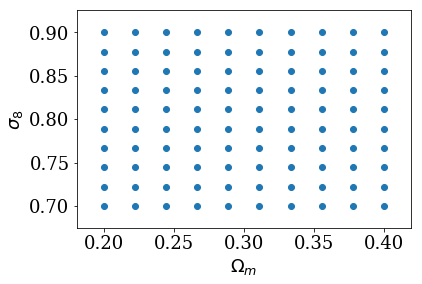

In [15]:
#Let's plot things to make sure it all looks good.
plt.scatter(parameter_grid[:, 1], parameter_grid[:, 0])
plt.xlabel(r"$\Omega_m$")
plt.ylabel(r"$\sigma_8$")

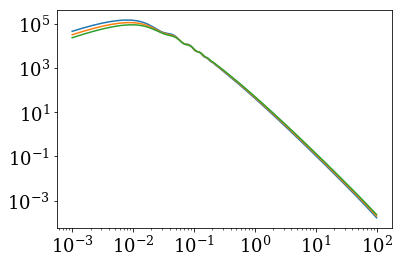

In [16]:
for i in range(3):
    plt.loglog(k, Pk_all[i, :Nk])

In [17]:
#Step 4 - save everything and pickle it
output_dict = {'k':k, 'zs':zs, 'parameters':parameter_grid, 'Pks':Pk_all}
import pickle
pickle.dump(output_dict, open("emulator_components.p", "wb"))